In [2]:
# Data handling libraries
import json
import numpy as np
import pandas as pd
from pandas import json_normalize

# PyTorch and Deep Learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# HuggingFace Transformers
from transformers import AutoTokenizer, AutoModel

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Progress bar
from tqdm import tqdm

# Set device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


# 1. Data Loading

In [3]:
# Load the training data from a JSON Lines file (one JSON object per line)
train_data = pd.read_json('train.jsonl', lines=True)
# The tweet data is nested. json_normalize flattens the nested JSON into columns.
train_data = json_normalize(train_data.to_dict(orient='records'))

# Load the Kaggle test data (which we will make predictions on)
kaggle_data = pd.read_json('kaggle_test.jsonl', lines=True)
# Also normalize the Kaggle data
kaggle_data = json_normalize(kaggle_data.to_dict(orient='records'))


# Separate features from the target variable for the training set
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']

X_kaggle = kaggle_data

In [4]:
import json

def print_features(obj, prefix=""):
    """
    Print JSON keys in a hierarchical structure.
    obj: dict, list, or primitive extracted from a tweet JSON
    prefix: dotted path string
    """
    if isinstance(obj, dict):
        for key, value in obj.items():
            path = f"{prefix}.{key}" if prefix else key
            print(path)  # print current path
            print_features(value, path)  # recursively explore
    elif isinstance(obj, list):
        # For lists, we don't print indices, we only describe structure
        for idx, item in enumerate(obj[:1]):  # only inspect first element if list is long
            path = f"{prefix}[]"
            print_features(item, path)
    else:
        # primitive type: stop recursion
        return


# Example usage:
tweet = {"extended_tweet": {"entities": {"urls": [], "hashtags": [{"indices": [148, 173], "text": "CEtaitBeaucoupMieuxAvant"}], "user_mentions": [], "symbols": []}, "full_text": "Aaaaah ! \"Les 3 Gr\u00e2ces\".... M\u00eame seules au beau milieu de Nonee part, elles me rappellent un temps (tr\u00e8s lointain) d'insouciance et de l\u00e9g\u00e8ret\u00e9... \n#CEtaitBeaucoupMieuxAvant", "display_text_range": [0, 173]}, "quoted_status": {"extended_tweet": {"extended_entities": {"media": [{"display_url": "pic.twitter.com/ULOht9eJjh", "indices": [280, 303], "sizes": {"small": {"w": 680, "h": 510, "resize": "fit"}, "large": {"w": 2048, "h": 1536, "resize": "fit"}, "thumb": {"w": 150, "h": 150, "resize": "crop"}, "medium": {"w": 1200, "h": 900, "resize": "fit"}}, "id_str": "1372125883406909442", "expanded_url": "https://twitter.com/GazetteLive34/status/1372125890600181762/photo/1", "media_url_https": "https://pbs.twimg.com/media/EwrFOJuWgAIJ_wX.jpg", "id": 1372125883406909442, "type": "photo", "media_url": "http://pbs.twimg.com/media/EwrFOJuWgAIJ_wX.jpg", "url": "https://t.co/ULOht9eJjh"}]}, "entities": {"urls": [{"display_url": "facebook.com/17226542282745\u2026", "indices": [256, 279], "expanded_url": "https://www.facebook.com/172265422827458/posts/3839831842737446/?d=n", "url": "https://t.co/dosgxTLdvT"}], "hashtags": [{"indices": [162, 174], "text": "confinement"}, {"indices": [177, 189], "text": "montpellier"}], "media": [{"display_url": "pic.twitter.com/ULOht9eJjh", "indices": [280, 303], "sizes": {"small": {"w": 680, "h": 510, "resize": "fit"}, "large": {"w": 2048, "h": 1536, "resize": "fit"}, "thumb": {"w": 150, "h": 150, "resize": "crop"}, "medium": {"w": 1200, "h": 900, "resize": "fit"}}, "id_str": "1372125883406909442", "expanded_url": "https://twitter.com/GazetteLive34/status/1372125890600181762/photo/1", "media_url_https": "https://pbs.twimg.com/media/EwrFOJuWgAIJ_wX.jpg", "id": 1372125883406909442, "type": "photo", "media_url": "http://pbs.twimg.com/media/EwrFOJuWgAIJ_wX.jpg", "url": "https://t.co/ULOht9eJjh"}], "user_mentions": [{"indices": [219, 233], "screen_name": "mariedeghetto", "id_str": "211119218", "name": "Marie Deghetto", "id": 211119218}, {"indices": [237, 252], "screen_name": "carocouffinhal", "id_str": "3760235123", "name": "Caro Couffinhal", "id": 3760235123}], "symbols": []}, "full_text": "Le 17 mars 2020, \u00e0 midi, la France se figeait. La date marque le d\u00e9but du premier confinement face \u00e0 l\u2019\u00e9pid\u00e9mie de Covid. Retour en images sur ce premier jour de #confinement \u00e0 #montpellier d\u00e9sert\u00e9e par ses habitants \ud83c\udfa5 @mariedeghetto et @carocouffinhal \ud83d\udc47\ud83c\udffb https://t.co/dosgxTLdvT https://t.co/ULOht9eJjh", "display_text_range": [0, 279]}, "in_reply_to_status_id_str": None, "in_reply_to_status_id": None, "created_at": "Wed Mar 17 10:01:19 +0000 2021", "in_reply_to_user_id_str": None, "source": "<a href=\"http://twitter.com/download/iphone\" rel=\"nofollow\">Twitter for iPhone</a>", "retweet_count": 0, "retweeted": False, "geo": None, "filter_level": "low", "in_reply_to_screen_name": None, "is_quote_status": False, "id_str": "1372125890600181762", "in_reply_to_user_id": None, "favorite_count": 0, "id": 1372125890600181762, "text": "Le 17 mars 2020, \u00e0 midi, la France se figeait. La date marque le d\u00e9but du premier confinement face \u00e0 l\u2019\u00e9pid\u00e9mie de\u2026 https://t.co/wsNI0YJr8x", "place": None, "lang": "fr", "quote_count": 0, "favorited": False, "possibly_sensitive": False, "coordinates": None, "truncated": True, "reply_count": 1, "entities": {"urls": [{"display_url": "twitter.com/i/web/status/1\u2026", "indices": [116, 139], "expanded_url": "https://twitter.com/i/web/status/1372125890600181762", "url": "https://t.co/wsNI0YJr8x"}], "hashtags": [], "user_mentions": [], "symbols": []}, "display_text_range": [0, 140], "contributors": None, "user": {"utc_offset": None, "friends_count": 394, "profile_image_url_https": "https://pbs.twimg.com/profile_images/866360377734508544/NZLf0hfA_normal.jpg", "listed_count": 223, "profile_background_image_url": "http://abs.twimg.com/images/themes/theme1/bg.png", "default_profile_image": False, "favourites_count": 65, "description": "Gazette Live est le premier #m\u00e9dia local d'infos #live en #France ! Retrouvez toute l'info du Grand #Montpellier 7j/7. #Occitanie #presse #journalisme #H\u00e9rault", "created_at": "Fri Jan 20 08:45:40 +0000 2012", "is_translator": False, "profile_background_image_url_https": "https://abs.twimg.com/images/themes/theme1/bg.png", "protected": False, "screen_name": "GazetteLive34", "id_str": "469144681", "profile_link_color": "FAB81E", "translator_type": "none", "id": 469144681, "geo_enabled": False, "profile_background_color": "FFFFFF", "lang": None, "profile_sidebar_border_color": "FFFFFF", "profile_text_color": "333333", "verified": False, "profile_image_url": "http://pbs.twimg.com/profile_images/866360377734508544/NZLf0hfA_normal.jpg", "time_zone": None, "url": "http://www.lagazettedemontpellier.fr", "contributors_enabled": False, "profile_background_tile": True, "profile_banner_url": "https://pbs.twimg.com/profile_banners/469144681/1510151632", "statuses_count": 6708, "follow_request_sent": None, "followers_count": 18409, "profile_use_background_image": True, "default_profile": False, "following": None, "name": "Gazette Live Mtp", "location": "Montpellier", "profile_sidebar_fill_color": "DDEEF6", "notifications": None}}, "in_reply_to_status_id_str": None, "in_reply_to_status_id": None, "created_at": "Wed Mar 17 10:26:14 +0000 2021", "in_reply_to_user_id_str": None, "source": "<a href=\"https://mobile.twitter.com\" rel=\"nofollow\">Twitter Web App</a>", "quoted_status_id": 1372125890600181762, "retweet_count": 0, "retweeted": False, "geo": None, "filter_level": "low", "in_reply_to_screen_name": None, "is_quote_status": True, "id_str": "1372132159608258560", "in_reply_to_user_id": None, "favorite_count": 0, "text": "Aaaaah ! \"Les 3 Gr\u00e2ces\".... M\u00eame seules au beau milieu de Nonee part, elles me rappellent un temps (tr\u00e8s lointain)\u2026 https://t.co/TzIeO54xpk", "place": None, "quoted_status_permalink": {"expanded": "https://twitter.com/GazetteLive34/status/1372125890600181762", "display": "twitter.com/GazetteLive34/\u2026", "url": "https://t.co/Wju7iTNvsF"}, "lang": "fr", "quote_count": 0, "favorited": False, "coordinates": None, "truncated": True, "timestamp_ms": "1615976774490", "reply_count": 0, "entities": {"urls": [{"display_url": "twitter.com/i/web/status/1\u2026", "indices": [116, 139], "expanded_url": "https://twitter.com/i/web/status/1372132159608258560", "url": "https://t.co/TzIeO54xpk"}], "hashtags": [], "user_mentions": [], "symbols": []}, "quoted_status_id_str": "1372125890600181762", "contributors": None, "user": {"utc_offset": None, "profile_image_url_https": "https://pbs.twimg.com/profile_images/889528082423574533/X02fN0fO_normal.jpg", "listed_count": 81, "profile_background_image_url": "http://abs.twimg.com/images/themes/theme1/bg.png", "default_profile_image": False, "favourites_count": 568, "description": "Midi \u00e0 ma porte - De tout sur tout - Le tout tr\u00e8s subjectif -\ud83d\ude09\n\"Le cha\u00eenon manquant entre le singe et l'homme c'est nous.\" (Pierre Dac)", "created_at": "Wed May 18 13:19:27 +0000 2011", "is_translator": False, "profile_background_image_url_https": "https://abs.twimg.com/images/themes/theme1/bg.png", "protected": False, "profile_link_color": "1DA1F2", "translator_type": "regular", "geo_enabled": False, "profile_background_color": "C0DEED", "lang": None, "profile_sidebar_border_color": "C0DEED", "profile_text_color": "333333", "profile_image_url": "http://pbs.twimg.com/profile_images/889528082423574533/X02fN0fO_normal.jpg", "time_zone": None, "url": None, "contributors_enabled": False, "profile_background_tile": False, "profile_banner_url": "https://pbs.twimg.com/profile_banners/300847179/1422110694", "statuses_count": 23668, "follow_request_sent": None, "profile_use_background_image": True, "default_profile": True, "following": None, "location": "France profonde.", "profile_sidebar_fill_color": "DDEEF6", "notifications": None}, "challenge_id": 73, "label": 0}
print_features(tweet)


extended_tweet
extended_tweet.entities
extended_tweet.entities.urls
extended_tweet.entities.hashtags
extended_tweet.entities.hashtags[].indices
extended_tweet.entities.hashtags[].text
extended_tweet.entities.user_mentions
extended_tweet.entities.symbols
extended_tweet.full_text
extended_tweet.display_text_range
quoted_status
quoted_status.extended_tweet
quoted_status.extended_tweet.extended_entities
quoted_status.extended_tweet.extended_entities.media
quoted_status.extended_tweet.extended_entities.media[].display_url
quoted_status.extended_tweet.extended_entities.media[].indices
quoted_status.extended_tweet.extended_entities.media[].sizes
quoted_status.extended_tweet.extended_entities.media[].sizes.small
quoted_status.extended_tweet.extended_entities.media[].sizes.small.w
quoted_status.extended_tweet.extended_entities.media[].sizes.small.h
quoted_status.extended_tweet.extended_entities.media[].sizes.small.resize
quoted_status.extended_tweet.extended_entities.media[].sizes.large
quoted_

quoted_status.retweet_count et quoted_status.favorite_count
éventuellement regarder quoted_status.user.friends_count et quoted_status.user.favourites_count et quoted_status.user.followers_count


In [5]:
#print 
print(X_train.iloc[1, :50])
print(X_train.iloc[1, 50:100])
print(X_train.iloc[1, 100:150])
print(X_train.iloc[1, 150:])

in_reply_to_status_id_str                                                                            NaN
in_reply_to_status_id                                                                                NaN
created_at                                                                     2021-03-17 13:02:06+00:00
in_reply_to_user_id_str                                                                              NaN
source                                                 <a href="https://mobile.twitter.com" rel="nofo...
quoted_status_id                                                                   1372170826334756864.0
retweet_count                                                                                          0
retweeted                                                                                          False
geo                                                                                                  NaN
filter_level                                           

drop : 
'source', 

# 2. Transforming into DataFrame

In [21]:
# Function to extract all relevant features (text + metadata)
def extract_features(row):
    # 1. Extract Full Text
    # Tweets can be truncated, storing the full version in 'extended_tweet.full_text'.
    text = row.get('text', '')
    if pd.notna(row.get('extended_tweet.full_text')):
        text = row['extended_tweet.full_text']
        
    # normalize text and append user URL tag
    text = str(text).replace('\n', ' ').strip()
    user_url = row.get('user.url', '')
    if pd.notna(user_url) and user_url:
        text = f"[TEXTE] {text} [PERSONAL_URL] {user_url}"
    else:
        text = f"[TEXTE] {text}"
        
        
    # 2. Extract Metadata
    # Helper to safely get values, handling NaNs
    def safe_get(key, default=0):
        val = row.get(key, default)
        if pd.isna(val):
            return default
        return val

    # Extract specific metadata features
    metadata = {
        'user_default_profile': int(safe_get('user.default_profile', False)),
        'user_profile_use_background_image': int(safe_get('user.profile_use_background_image', False)),
        'user_statuses_count': float(safe_get('user.statuses_count', 0)),
        'user_profile_background_tile': int(safe_get('user.profile_background_tile', False)),
        'user_geo_enabled': int(safe_get('user.geo_enabled', False)),
        'user_is_translator': int(safe_get('user.is_translator', False)),
        'user_favourites_count': float(safe_get('user.favourites_count', 0)),
        'user_listed_count': float(safe_get('user.listed_count', 0))
    }
    
    return pd.Series({'full_text': text, **metadata})


# Apply extraction to training and test data
print("Extracting features...")
train_features = X_train.apply(extract_features, axis=1)
kaggle_features = X_kaggle.apply(extract_features, axis=1)

# List of numerical columns to log-transform
log_cols = ['user_statuses_count', 'user_favourites_count', 'user_listed_count']

# Apply log transform (log1p to handle zeros)
for col in log_cols:
    train_features[col] = np.log1p(train_features[col])
    kaggle_features[col] = np.log1p(kaggle_features[col])

# Separate metadata for scaling
metadata_cols = [c for c in train_features.columns if c != 'full_text']
metadata_train = train_features[metadata_cols]
metadata_kaggle = kaggle_features[metadata_cols]

# Scale numerical values
scaler = StandardScaler()
metadata_train_scaled = scaler.fit_transform(metadata_train)
metadata_kaggle_scaled = scaler.transform(metadata_kaggle)

print("Features extracted and scaled.")
print("Metadata shape:", metadata_train_scaled.shape)

Extracting features...
Features extracted and scaled.
Metadata shape: (154914, 8)
Features extracted and scaled.
Metadata shape: (154914, 8)


In [27]:
training_data = [{'text': train_features.iloc[i]['full_text'], 'metadata': metadata_train_scaled[i], 'label': y_train.iloc[i]} for i in range(len(train_features))]
test_data = [{'text': kaggle_features.iloc[i]['full_text'], 'metadata': metadata_kaggle_scaled[i]} for i in range(len(kaggle_features))]

In [29]:
training_data[1]

{'text': "[TEXTE] Depuis un certain temps, Le Gorafi n'a même plus vraiment besoin de caricaturer l'information. C'est inquiétant... [PERSONAL_URL] http://www.gauchebdo.ch",
 'metadata': array([ 0.82404365,  0.46892572, -0.44898571, -0.34117553, -0.79122387,
        -0.01270456,  0.47412074, -0.64464264]),
 'label': np.int64(0)}

Python(22779) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Tokenizing 154914 tweets to find optimal length...


100%|██████████| 154914/154914 [00:14<00:00, 10582.53it/s]



Min: 7
Max: 332
Mean: 58.32
Median: 55.0
95th percentile: 109.0
99th percentile: 127.0


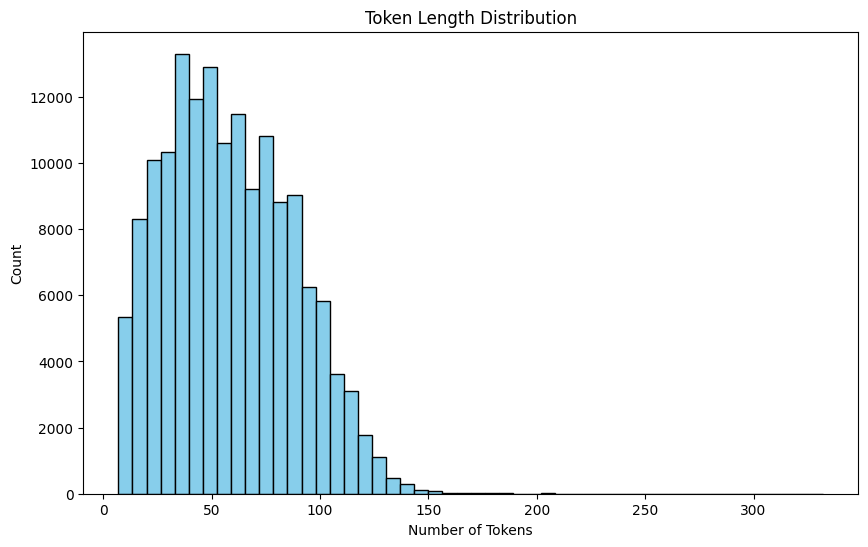

In [30]:
from transformers import AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt

# Initialize tokenizer
tokenizer_name = "cardiffnlp/twitter-xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# Get texts from training_data
texts = [item['text'] for item in training_data]

# Calculate lengths
print(f"Tokenizing {len(texts)} tweets to find optimal length...")
lengths = []
for t in tqdm(texts):
    # encode returns list of ids
    lengths.append(len(tokenizer.encode(t, add_special_tokens=True)))

lengths = np.array(lengths)

# Statistics
print(f"Min: {np.min(lengths)}")
print(f"Max: {np.max(lengths)}")
print(f"Mean: {np.mean(lengths):.2f}")
print(f"Median: {np.median(lengths)}")
p95 = np.percentile(lengths, 95)
p99 = np.percentile(lengths, 99)
print(f"95th percentile: {p95}")
print(f"99th percentile: {p99}")

# Plot
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Token Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Count")
plt.show()